<a href="https://colab.research.google.com/github/soulayman-al-abdallah/Ai-Stable-Diffusion/blob/main/Stable_Diffusion_Art_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ai digital art generation using Stable Diffusion

---

**Stable Diffusion** is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and runs on a GPU with at least 10GB VRAM.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This colab is inspired and adabted from the official notebook implementing Stable Diffusion by Hugging Face [here](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb), and the work done in this [video](https://www.youtube.com/watch?v=ltLNYA3lWAQ&t=413s&ab_channel=EdanMeyer).


What we do in this colab:
* **Text-2-Image** generation using a **ready-to-use** pipeline
* Understanding the parameters that lead to output variation
* **Text-2-Image** generation using a **customized** pipeline
* Visualizing the image denoising via a video
* Generating **similar images** by changing the latents
* **Image-2-Image** generation by fixing the original latents and listening to a prompt



---



#Preparations and Importing

Making sure that the runtime type is: GPU.

In [1]:
!nvidia-smi

Wed Nov  2 10:31:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers==0.2.4                             # a library from HuggingFace for diffusion models
!pip install transformers scipy ftfy                      # to import CLIPTextModel, CLIPTokenizer from it for encoding purposes
!pip install "ipywidgets>=7,<8"
!pip install huggingface_hub

In [ ]:

# As google colab has disabled external widgtes, we need to enable it explicitly. Run the following cell to be able to use notebook_login
from google.colab import output
output.enable_custom_widget_manager()

# Now you can login with your user token, to HuggingFace, from where we will be downloading our models
from huggingface_hub import notebook_login
notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode
from tqdm.auto import tqdm

import torch
from torch import autocast                                                                #to run inference faster because the use of half-precision. 
                                                                                          #autocast helps improve runtime performance by automatically casting down 
                                                                                          #data to 16-bit for some computations. https://effectivemachinelearning.com/PyTorch/8._Faster_training_with_mixed_precision
from torch.nn import functional as F

from diffusers import StableDiffusionPipeline, AutoencoderKL                              #ready-to-use StableDiffusionPipeline     VAE
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler           #UNet architecture and 2 shedulers
from diffusers.schedulers.scheduling_ddim import DDIMScheduler                            #a 3rd scheduler

from transformers import CLIPTextModel, CLIPTokenizer                                     #text embedding tools


In [ ]:
torch_device = "cuda" if torch.cuda.is_available() else "cpu"



---



# Built-in StableDiddusionPipeline

## Instance Creation

In [ ]:
#loading the ready-to-use model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",           # chosen model id, load EVERYTHING = its pre-trained weights of its components
                                               revision="fp16",                           # to run it freely on Colab, we're loading the weights from the half-precision branch fp16
                                               torch_dtype=torch.float16,                 # tell diffusers to expect the weights in float16 precision
                                               use_auth_token=True)                       # accept license


pipe = pipe.to("cuda")                                                                    # moving the pipeline to GPU to have faster inference.

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

**It will give the following error:**
(Access to model CompVis/stable-diffusion-v1-4 is restricted and you are not in the authorized list. Visit https://huggingface.co/CompVis/stable-diffusion-v1-4 to ask for access.)
**To fix it:**
Click on the link in the error, click the checkbox, accept, rerun the cell and it works 👍

⛩ **CHANGO** *If you want to ensure the highest possible precision, please make sure to remove revision="fp16" and torch_dtype=torch.float16 at the cost of a higher memory usage.*

In [ ]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.2.4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



---




## Image Generation

⛩ **CHANGO** *Using autocast will run inference faster because it uses half-precision.*

0it [00:00, ?it/s]

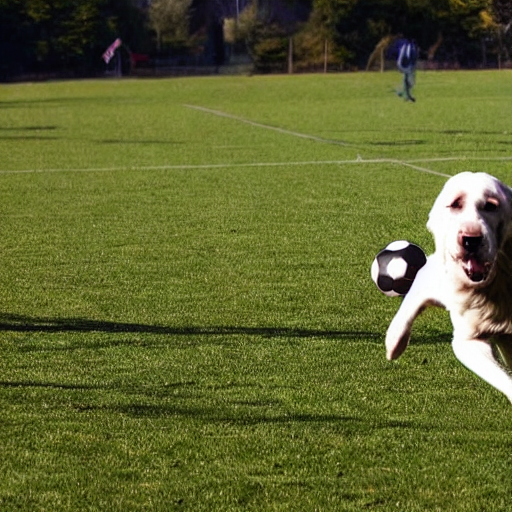

In [ ]:
prompt = "a dog playing football ball"
with autocast("cuda"):
  image = pipe(prompt)['sample'][0]

image



---



###▶ Seed Fixing

In [ ]:
import torch
generator = torch.Generator("cuda").manual_seed(1024)             #to get the same image everytime we run this cell, we need to fix the random seed
with autocast("cuda"):
  image = pipe(prompt, generator=generator)['sample'][0]

image

###▶ Change the number of inference steps

In [ ]:
import torch                                                                               #⛩ CHANGO
generator = torch.Generator("cuda").manual_seed(1024)
with autocast("cuda"):
  image = pipe(prompt, num_inference_steps=15, generator=generator)['sample'][0]           # more is better quality, default is 50 is enough

image                                                                                      # expect same image but worser

###▶ Change the guidance scale

In [ ]:
#The other parameter in the pipeline call is guidance_scale.                               #⛩ CHANGO
#It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. 
#In simple terms classifier free guidance forces the generation to better match with the prompt. 
#Values between 7 and 8.5 are usually good choices for Stable Diffusion. 
#By default the pipeline uses a guidance_scale of 7.5, if you use a very large number the images might look good, but will be less diverse.
#guidance_scale == 1 corresponds to doing no classifier-free guidance.

### Displaying multiple images

0it [00:00, ?it/s]

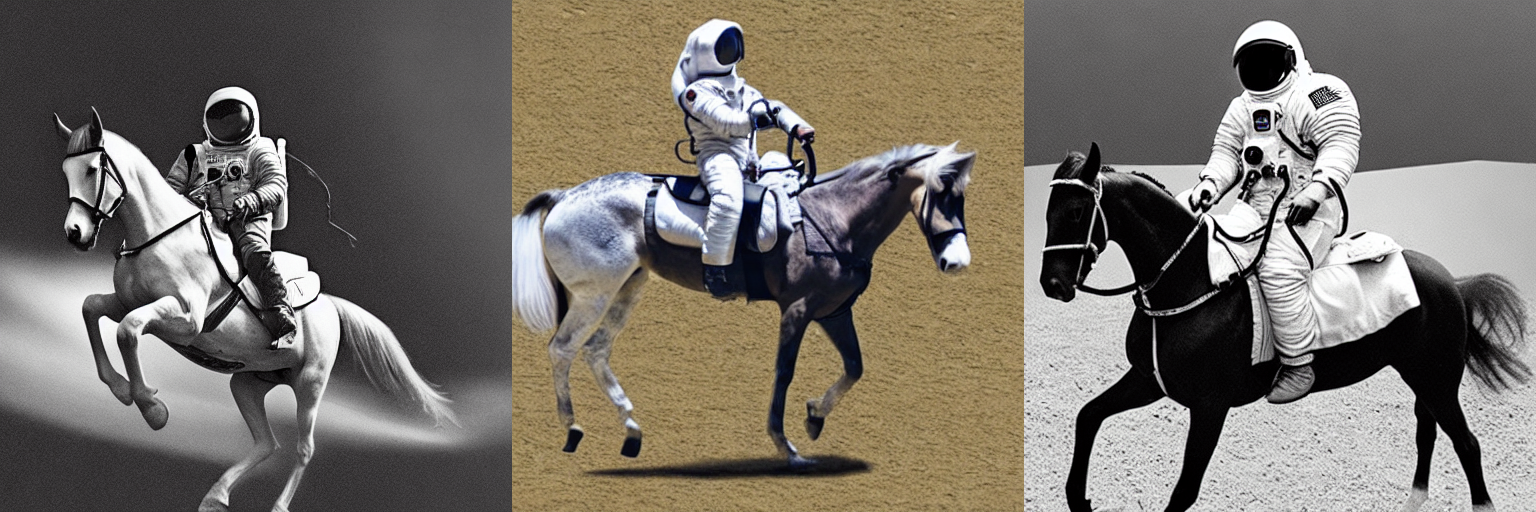

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

#We'll send the list to the pipeline instead of the string we used before.
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

with autocast("cuda"):
  images = pipe(prompt)['sample']

grid = image_grid(images, rows=1, cols=3)
grid

# you can save the grid with
# grid.save(f"astronaut_rides_horse.png")



---



---



---



#Customized StableDiffusionPipeline

Writing a custom inference pipeline is an advanced use of the diffusers library that can be useful to switch out certain components, such as the **VAE** or **scheduler** explained above. ⛩ CHANGO ⛩ CHANGO

text_encoder: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as BERT. ⛩ CHANGO

tokenizer. It must match the one used by the text_encoder model.
scheduler: The scheduling algorithm used to progressively add noise to the image during training.
unet: The model used to generate the latent representation of the input.
vae: Autoencoder module that we'll use to decode latent representations into real images.

## **Loading the model components: Vae + text embedder + Unet**

In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# 4. Create a scheduler for inference.  instead of loading the pre-defined scheduler, we load a K-LMS scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.layer_norm2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.22.layer_norm1.weight', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.6.layer_norm2.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.mlp.fc

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

**Moving the models to the GPU**

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

**Setting some parameters values**

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

## **I- Getting text embeddings**

For classifier-free guidance, we need to do two forward passes: one with the conditioned input (text_embeddings), and another with the unconditional embeddings (uncond_embeddings).

In [ ]:
def get_text_embeds(prompt):
  
  # Tokenize text and get embeddings
  text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  # Do the same for unconditional embeddings    for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional text_embeddings (batch_size and seq_length)
  uncond_input = tokenizer([''] * len(prompt), padding='max_length', max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])             # vertical concatination of both embeddings, each 77 x 768
  return text_embeddings                                                        #torch.Size([2, 77, 768])

# test_embeds = get_text_embeds(['cute dog'])
# print(test_embeds)
# print(test_embeds.shape)

In [ ]:
test_embeds = get_text_embeds(['cute happy dog'])
print(test_embeds)
print(test_embeds.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.4771, -0.4680,  0.0514,  ..., -0.1052, -0.4885,  0.0188],
         [-1.7803, -0.7484,  0.8876,  ...,  0.8458, -1.3769, -1.3963],
         ...,
         [-1.4179,  0.5734, -0.5966,  ..., -0.0492, -1.5999, -1.6735],
         [-1.4128,  0.5659, -0.5829,  ..., -0.0479, -1.5952, -1.6892],
         [-1.3724,  0.5794, -0.5144,  ..., -0.0020, -1.5567, -1.7085]]],
       device='cuda:0')
torch.Size([2, 77, 768])




---



## **II- Producing denoised conditioned latents**

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5,
                    latents=None):                                                                            # allowing passing custom latents or if I want to fix it to fix the output & analyse
  
  
  # starting=creating a random noisy latent space
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))         #latents.shape gives torch.Size([1, 4, 64, 64])
  latents = latents.to(torch_device)                                                                          
                                                                                                              # Later, the model will transform this latent representation (pure noise) into a 512 × 512 image

  # The scheduler will compute the sigmas and exact time step values to be used during the denoising process.
  scheduler.set_timesteps(num_inference_steps)                                                                # setting time steps for the scheduler.       For each step, UNet predicts what the noise is, we need to scale it in a way that at the end (after 50 i.e.), w achieve the awaitened end product
  latents = latents * scheduler.sigmas[0]                                                                     #The K-LMS scheduler needs to multiply the latents by its sigma values

  #The Denoising loop
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']             #predicting the noise of each step

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)                                                # getting latents for text embeddings & unconditional embeddings (empty prompt)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)                 # calculating the difference btw them, and scaling it, and adding it to unconditioned
                                                                                                              # to push it more towards the prompt
      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']                                         #removing the noise of each step
  
  return latents                                                                                              #torch.Size([1, 4, 64, 64]) which means 1 latent x the shape of the latency 4 x 64 x 64

# test_latents = produce_latents(test_embeds)
# print(test_latents)
# print(test_latents.shape)

In [ ]:
test_latents = produce_latents(test_embeds)
print(test_latents)
print(test_latents.shape)

0it [00:00, ?it/s]

tensor([[[[ 0.1199,  0.2839,  0.9910,  ...,  0.5631,  0.4733,  1.0676],
          [ 0.6541,  0.6492,  0.0453,  ...,  1.1842,  0.1301,  1.0225],
          [ 0.6764, -0.5007,  1.1039,  ...,  1.2057,  0.7741,  0.2336],
          ...,
          [-0.5692, -1.5757, -0.4283,  ...,  0.3444, -0.4433,  1.0023],
          [-0.3380, -0.2140, -1.6134,  ..., -0.5928, -0.2908,  0.9113],
          [-0.3759, -1.0448, -0.0481,  ..., -0.0699, -0.1645,  0.3066]],

         [[ 0.5100,  0.4020,  0.2127,  ...,  1.5733,  1.0619,  0.6880],
          [-0.4556,  0.4694,  1.0678,  ...,  1.0133,  0.6697,  0.7785],
          [ 0.7145,  1.0051,  0.6823,  ...,  0.8537,  0.4167,  1.1633],
          ...,
          [-0.4810, -0.2084, -0.8381,  ..., -1.3380,  0.5833, -0.7315],
          [-1.4313,  0.3454,  0.4008,  ..., -1.4776, -0.0937,  0.5426],
          [ 0.3577,  0.7184, -0.4861,  ..., -0.8259, -0.8506, -0.4824]],

         [[-0.2788,  0.2574,  0.3276,  ..., -0.2513, -0.1777, -0.2102],
          [-0.0042, -0.2743, -



---



## **III- Decoding the generated latents to an image**

In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)                                                  #using the vae to decode the generated latents

  imgs = (imgs / 2 + 0.5).clamp(0, 1)                                           #converting the image to PIL so we can display or save it
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images                                                             # we should select index 0 from the returned sequence

# imgs = decode_img_latents(test_latents)
# imgs[0]

## **Pipeline Creation**

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None):
  
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
  
  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

0it [00:00, ?it/s]

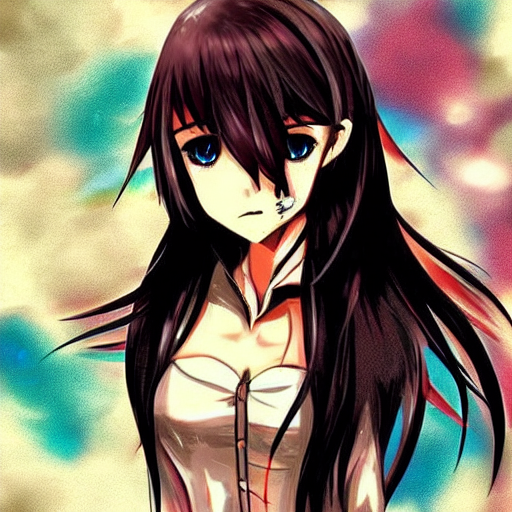

In [ ]:
#prompt_to_img(prompts='Super cool anime character', height=512, width=512, num_inference_steps=20)[0]
prompt_to_img('Super cool anime character', 512, 512, 20)[0]



---



##**__Make a video**

We need to save all the 50 latents images to get the 50 image representations to make an evolution video

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False):                                                                        #adding this variable to return all 50 i.e. latents
  
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))
  latents = latents.to(torch_device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  latent_hist = [latents]                                                                                             # a list to track all the latents
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']
      latent_hist.append(latents)                                                                                     # at the end of each step, append the step's latents
  
  if not return_all_latents:                                                                                          # only when return_all_latents Fn parameter is False, return latents without history
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents                                                                                                  # else return all latents history concatinated







def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, latents=None, 
                  return_all_latents=False,                                                                           #adding this variable to handle all 50 i.e. latents
                  batch_size=2):                                                                                      # to avoid overloading the GPU when doing everything below at once
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents)                                                                          #passing the argument False or True regarding returning latents history
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):                                                                  #creating 50 images out of 50 image latents from the history
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

In [ ]:
prompt = 'Starry night with a violet sky digital art'
video_frames = prompt_to_img(prompt, num_inference_steps=40, return_all_latents=True)

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [ ]:
vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)



---



#Similar image (by perturbing latents)

Here similar image not same image like the case of "Seed Fixing"

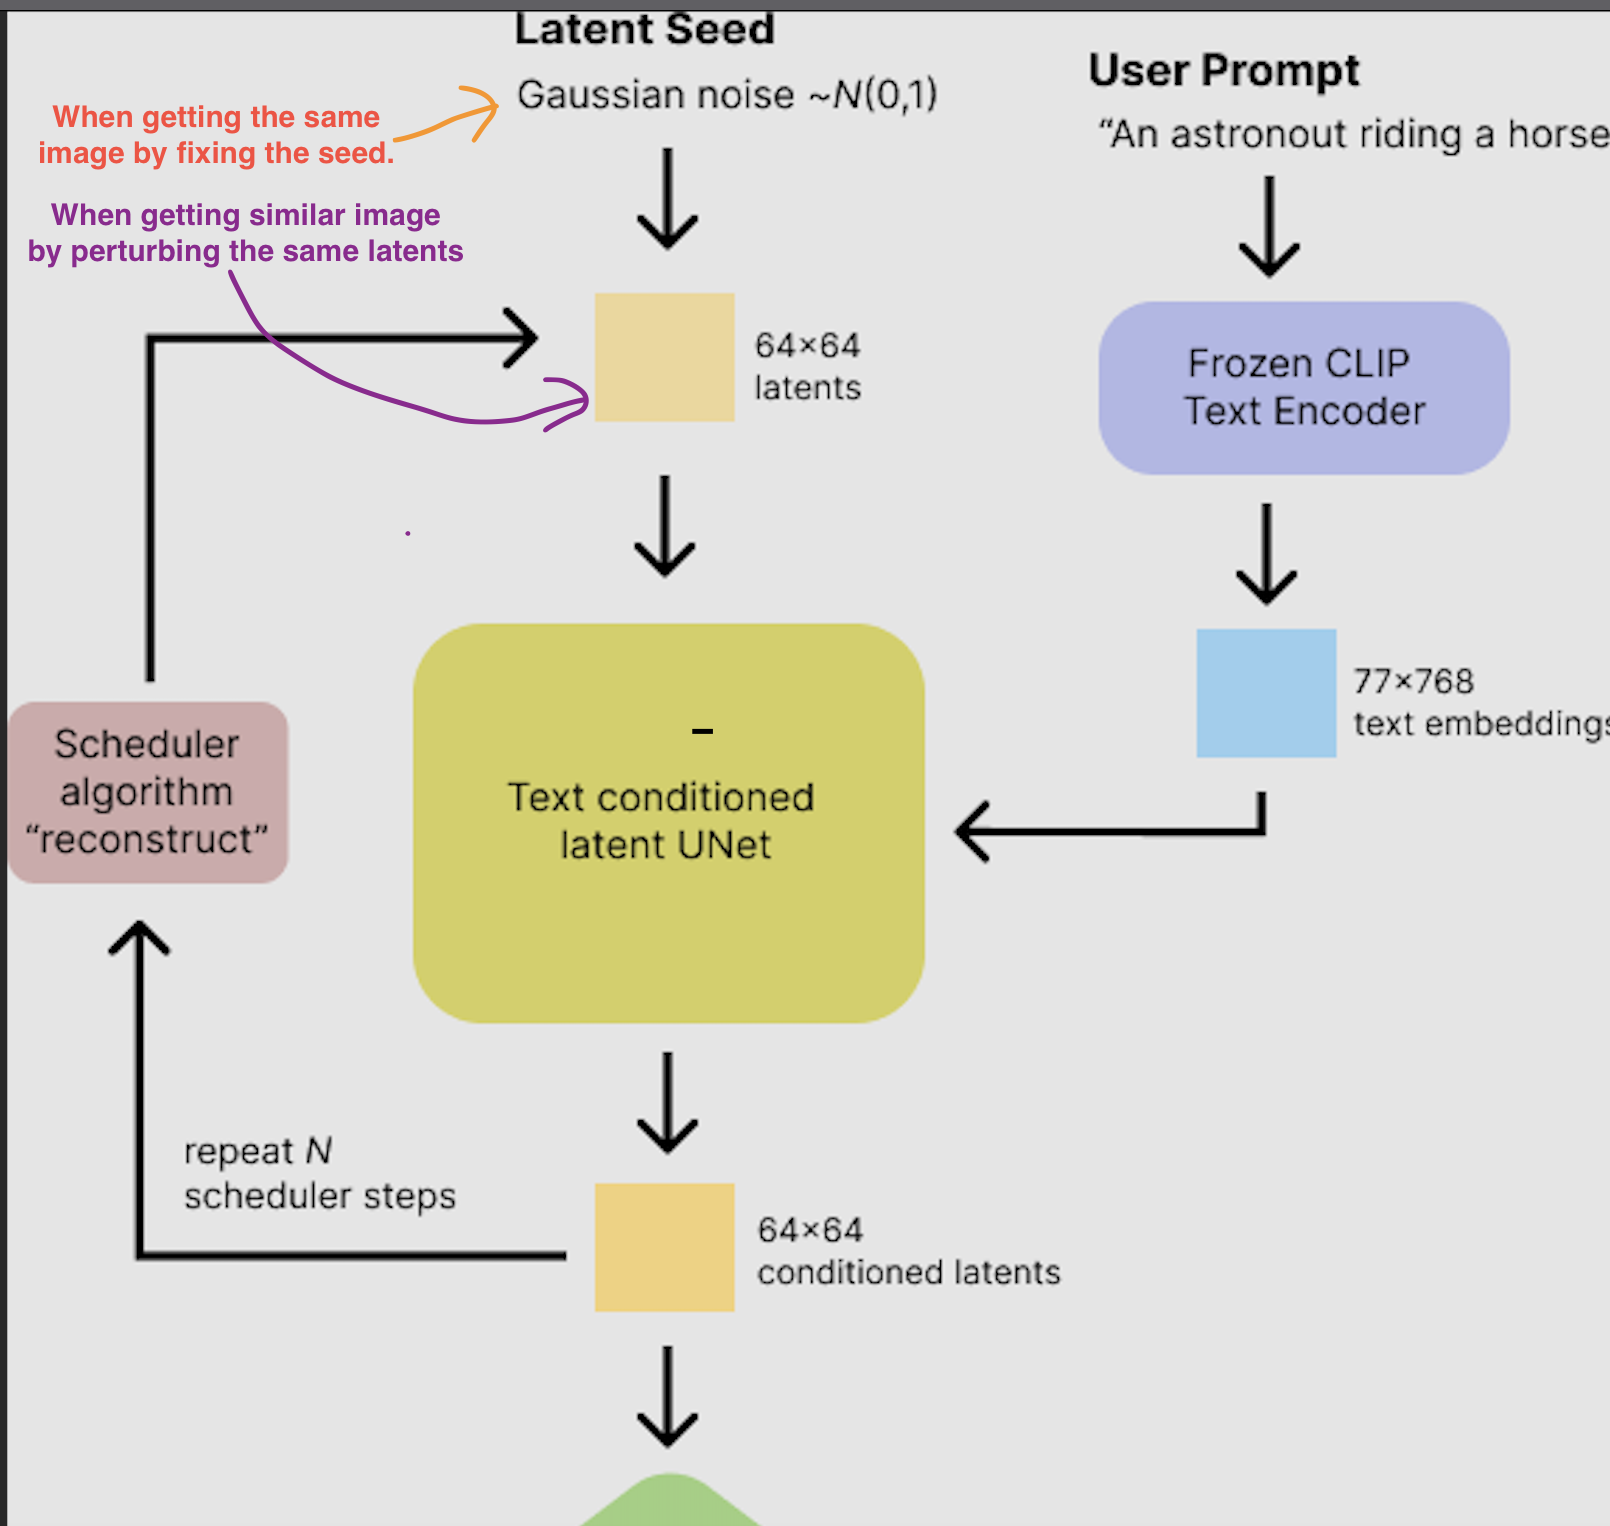

**Generating one image**

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

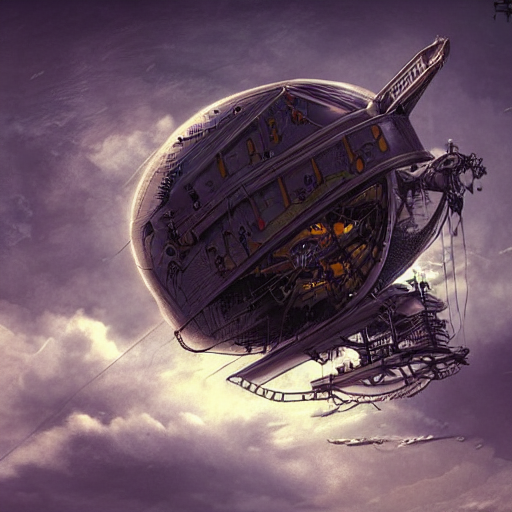

In [ ]:
prompt = 'Steampunk airship bursting through the clouds, cyberpunk art'
latents = torch.randn((1, unet.in_channels, 512 // 8, 512 // 8))
img = prompt_to_img(prompt, num_inference_steps=20, latents=latents)[0]
img

**Creating the perturbation Fn & generating a similar image**

In [ ]:
def perturb_latents(latents, scale=0.1):                                  #scale = degree of perturbation
  noise = torch.randn_like(latents)                                       #takes the same latents of the previously generated image
  new_latents = (1 - scale) * latents + scale * noise                     #produce new perturbated latents
  return (new_latents - new_latents.mean()) / new_latents.std()

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

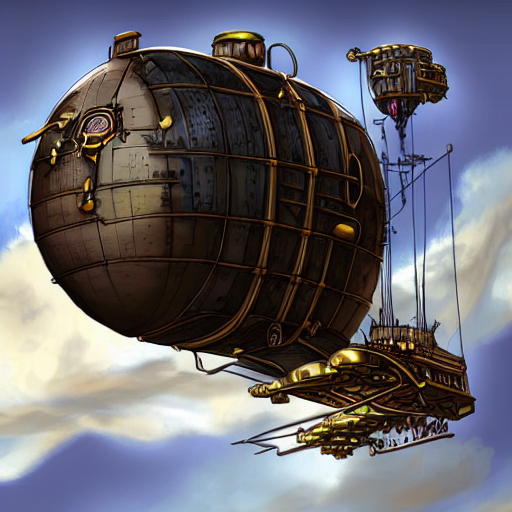

In [ ]:
new_latents = perturb_latents(latents, 0.4)
img = prompt_to_img(prompt, num_inference_steps=20, latents=new_latents)[0]
img



---



#Image-to-image

**Generating an input image**

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

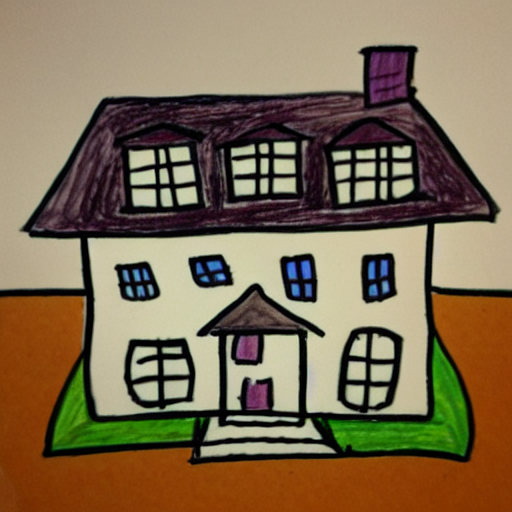

In [ ]:
prompt = 'house poorly drawn by a child'
img = prompt_to_img(prompt, num_inference_steps=30)[0]
img

**Encoding the input image with VAE also**

In [ ]:
def encode_img_latents(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]

  img_arr = np.stack([np.array(img) for img in imgs], axis=0)
  img_arr = img_arr / 255.0
  img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
  img_arr = 2 * (img_arr - 0.5)

  latent_dists = vae.encode(img_arr.to(torch_device))
  latent_samples = latent_dists.sample()
  latent_samples *= 0.18215

  return latent_samples

In [ ]:
img_latents = encode_img_latents([img])                                   #image representation  ---> image latents
# dec_img = decode_img_latents(img_latents)[0]
# dec_img

**Loading and instantiating another Scheduler**

The way **LMSDiscreteScheduler** (**K-LMS scheduler**) works:

Everytime you calculate a new image,
it stores the last few images,
so it can get the trajectory that you're going.

While in img-to-img,
we are not starting from a random latent space,
we are starting from the latent space of the input image when VAE encoded,
so when we are denoising here, we don't have that trajectory up to that point.

So we will used this scheduler instead: **DDIMScheduler**.
- Simpler
- Better fit for such cases not like the general approach (earlier)

In [ ]:
# New scheduler for img-to-img
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

We want to add some noise to the latents of the input image (less backward diffusion), as if it is not done being generated yet = turning it into a half done image, 

(now backward diffusion = denoising) and from there we will give a new prompt, and then have the model redo the undeffusion process from about halfway into the process, and then adapting the image to what the new prompt is saying.

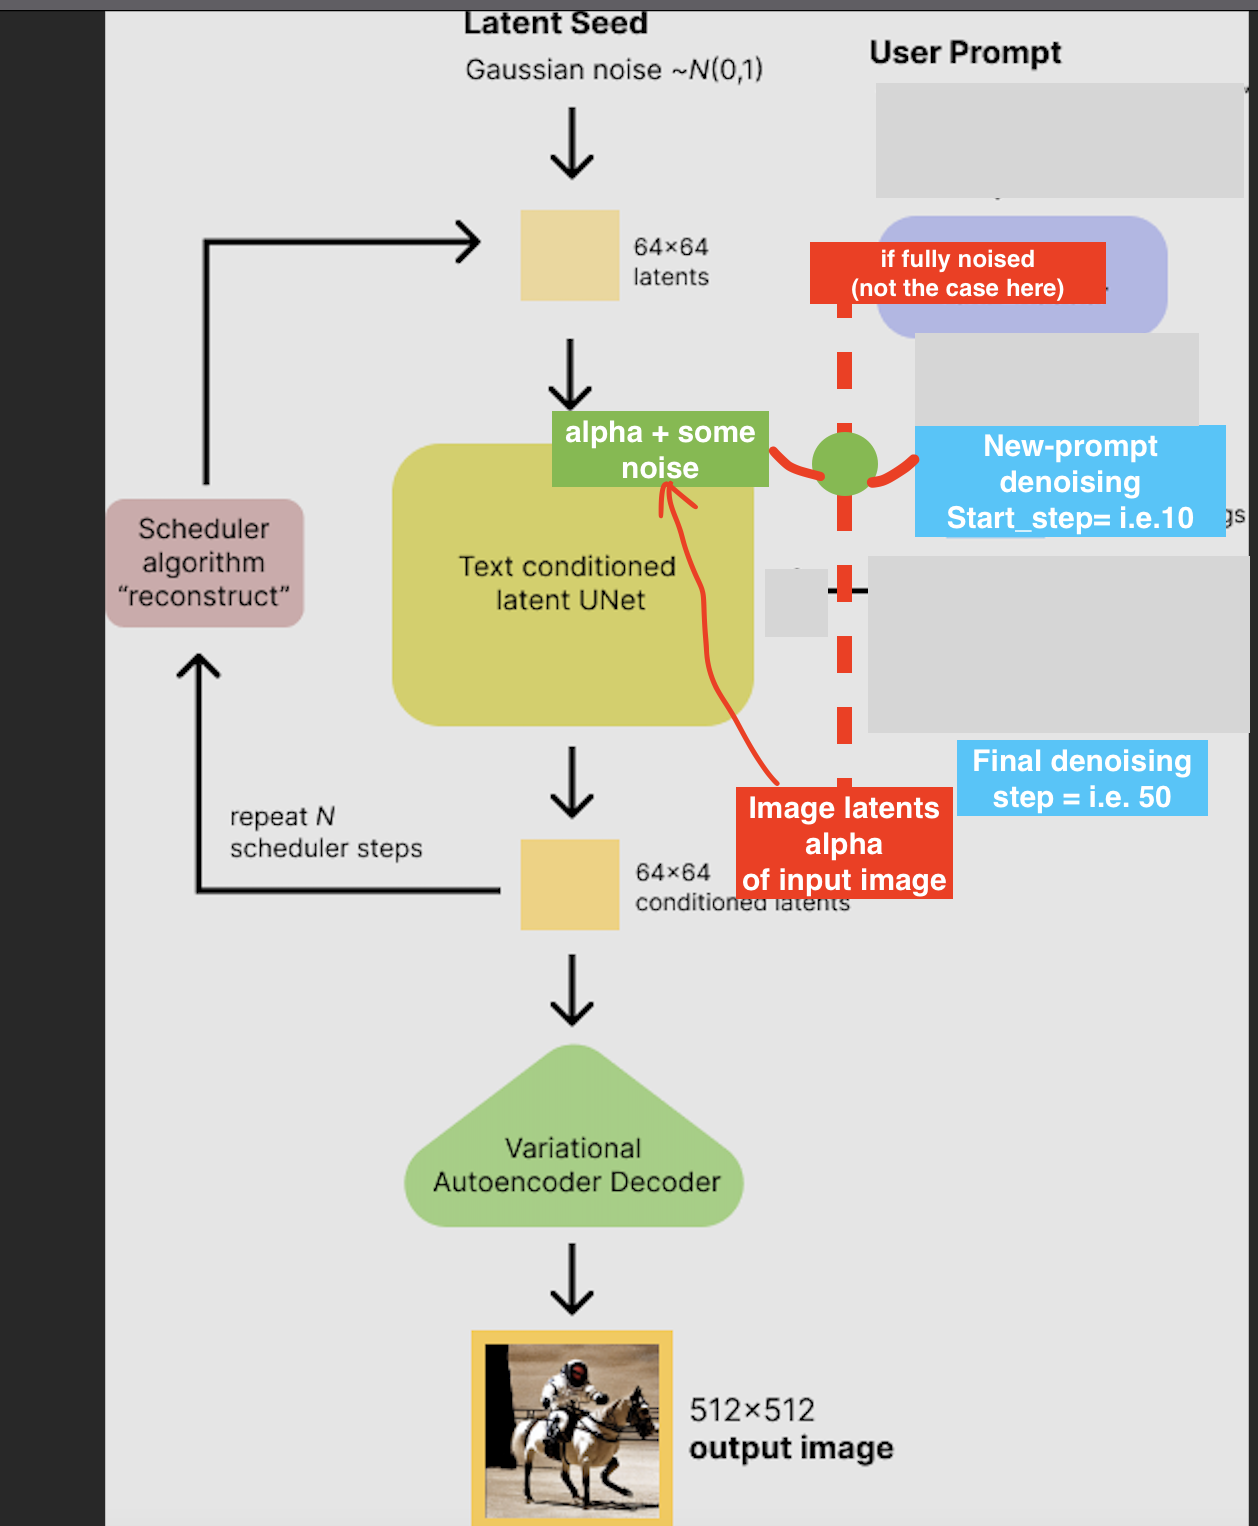

In [ ]:
def produce_latents(text_embeddings, height=512, width=512, num_inference_steps=50, 
                    guidance_scale=7.5, latents=None, return_all_latents=False,
                    start_step=10):                                                         #start_step: the steps (in the backward diffusion = denoising) at which the influence of the new prompt starts
                                                                                            #as if we're already 10 steps into the process of creating the input image itself  
                                                                                            # and want to generate a new image from there
  #default randomly generated latents OR passed latents as argument
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(torch_device)

  #using the new scheduler's instance
  scheduler.set_timesteps(num_inference_steps)
  if start_step > 0:
    start_timestep = scheduler.timesteps[start_step]
    start_timesteps = start_timestep.repeat(latents.shape[0]).long()

    noise = torch.randn_like(latents)
    latents = scheduler.add_noise(latents, noise, start_timesteps)                           # adding a little bit of noise to the latents (less backward diffusion ;) )
                                                                                             # it means adding noise to the image as if it was at that time step when originallyyyy being generated

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps[start_step:])):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2, start_step=0):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents, start_step=start_step)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

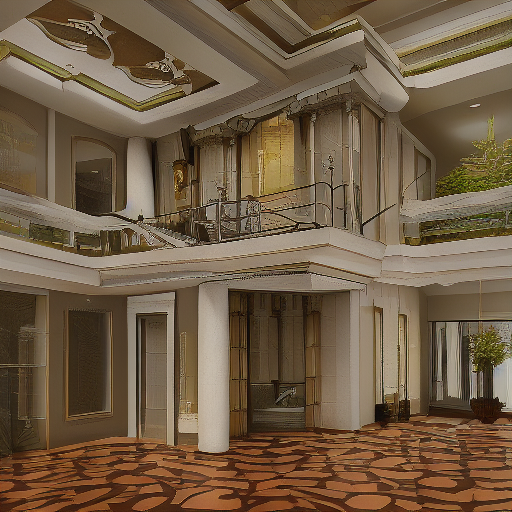

In [ ]:
prompt = 'luxurious house  3D render'
new_img = prompt_to_img(prompt, num_inference_steps=70, 
                    latents=img_latents,                    # the latents argument: img_latents is = encode_img_latents([img]) where img is a generated image 
                                                                                                                                         #OR is any PIL image
                    start_step=4)[0]
new_img



---

